In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from data_utils import plot_data

# Importing Data

## Define Data Folders

In [71]:
parent_data_folder = "Y:/Downloads/tests/"
raw_test_name_1 = parent_data_folder + "Hat_1_2023-06-07_17--03--19"
raw_test_name_1 = raw_test_name_1 + ".csv"

raw_test_name_2 = parent_data_folder + "Hat_2_2023-06-07_17--03--19"
raw_test_name_2 = raw_test_name_2 + ".csv"


print(raw_test_name_1)
print(raw_test_name_2)

Y:/Downloads/tests/Hat_1_2023-06-07_17--03--19.csv
Y:/Downloads/tests/Hat_2_2023-06-07_17--03--19.csv


## Open and merge two DFs

In [72]:
import pandas as pd

# Define the chunk size
chunk_size = 50000 # Modify this value based on your need

# Initialize empty lists to hold the chunks from both files
chunks_file1 = []
chunks_file2 = []

# Read the first csv file in chunks
try:
    for chunk in pd.read_csv(raw_test_name_1, chunksize=chunk_size):
        chunks_file1.append(chunk)
except ParserError as e:
    # Handle the specific error
    print(f"ParserError: {e}")
    # Additional error handling logic

# Read the second csv file in chunks
try:
    for chunk in pd.read_csv(raw_test_name_2, chunksize=chunk_size):
        chunks_file2.append(chunk)
except ParserError as e:
    # Handle the specific error
    print(f"ParserError: {e}")
    # Additional error handling logic

# Concatenate all chunks from the first file
df1 = pd.concat(chunks_file1, axis=0)

# Concatenate all chunks from the second file
df2 = pd.concat(chunks_file2, axis=0)
df2 = df2.drop('time', axis=1)
df2 = df2.rename(columns={'value_1': 'value_3', 'value_2': 'value_4'})


# Merge the two dataframes
# Assuming that they can be merged on the index
data_frame = pd.concat([df1, df2], axis=1)

In [73]:
data_frame['time'] = pd.Series(range(len(data_frame))) / 10240
data_frame = data_frame.rename(columns={'value_1': 'HAT0_CH0', 'value_2': 'HAT0_CH1', 'value_3': 'HAT1_CH0', 'value_4': 'HAT1_CH1'})

## Creates a csv files with the combined data

In [189]:
#combined_test_name = re.sub("Hat_1", "Hat_Combined", raw_test_name_1)
#data_frame.to_csv(combined_test_name, index=False)

In [74]:
data_frame.head()

,time,HAT0_CH0,HAT0_CH1,HAT1_CH0,HAT1_CH1
0,0.000000,-5.105859,5.111617,-4.015002,4.004396
1,0.000098,5.112546,5.111617,0.800079,-2.678189
2,0.000195,-5.105859,5.111617,1.101481,5.107575
3,0.000293,5.112546,5.111617,-5.109585,0.955626
4,0.000391,0.487094,5.111617,-5.020501,-0.775122


In [67]:
print(data_frame)

               time  HAT0_CH0  HAT0_CH1  HAT1_CH0  HAT1_CH1
0          0.000000  0.628083  0.612112  0.434218  0.481906
1          0.000098  0.591256  0.575329  0.397053  0.444457
2          0.000195  0.575253  0.559440  0.383067  0.430189
3          0.000293  0.546541  0.530768  0.354834  0.401633
4          0.000391  0.526640  0.510944  0.336630  0.383123
...             ...       ...       ...       ...       ...
8715328  851.106250  0.045689  0.042548       NaN       NaN
8715329  851.106348  0.027701  0.025759       NaN       NaN
8715330  851.106445  0.014586  0.012901       NaN       NaN
8715331  851.106543  0.001254  0.000703       NaN       NaN
8715332  851.106641 -0.009010 -0.008834       NaN       NaN

[8715333 rows x 5 columns]


## Shape into Dataframe

# Meta Validation

### Maximum, minimums and average

In [75]:
# Calculate the maximum, minimum, and average values
max_values = data_frame.max()
min_values = data_frame.min()
average_values = data_frame.mean()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Maximum': max_values, 'Minimum': min_values, 'Average': average_values})

# Round the values to 1 decimal place
stats_df_rounded = stats_df.round(1)

# Display the results in a tabular format
print(stats_df_rounded)

# Note: values of 0.0 indicate that - most likely - the channel was not used

          Maximum  Minimum  Average
time        212.0      0.0    106.0
HAT0_CH0      5.1     -5.1      0.0
HAT0_CH1      5.1     -5.1      0.0
HAT1_CH0      5.1     -5.1      0.0
HAT1_CH1      5.1     -5.1      0.0


### Data Points & Recording Time

In [76]:
# Access the first column using its index and count the number of data points
#time_values = data_frame.iloc[:, 0]
time_values = data_frame["time"]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 2170453
Data was recorded for 211.96 seconds
Data was recorded for 3.53 minutes
Data was recorded for 0.06 hours


### Sampling rate, Consistency and CV

In [24]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10240  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")

Expected sampling rate: 10240 Hz
Effective sampling rate: 10240.00 Hz
Number of time intervals exceeding 5.0% deviation: 0
Percentage of time intervals exceeding 5.0% deviation: 0.00%


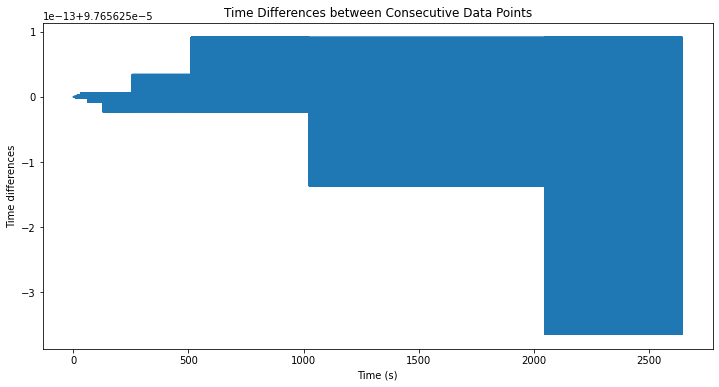

In [195]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

In [25]:
# Calculate the duration in seconds
start_time = data_frame.iloc[0, 0]
end_time = data_frame.iloc[-1, 0]
duration_seconds = end_time - start_time

# Get the file size in bytes
file_size_bytes = os.path.getsize(raw_test_name_1)*2

# Convert file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# Calculate disk space per second in megabytes
disk_space_per_second_mb = file_size_mb / duration_seconds

print(f"Disk space per second: {round(disk_space_per_second_mb,2)} MB/s")

print(f"Disk space per minute: {round(disk_space_per_second_mb*60,2)} MB/min")

print(f"Disk space per hour: {round(disk_space_per_second_mb*60*60/1024,2)} GB/hour")

Disk space per second: 2.0 MB/s
Disk space per minute: 120.07 MB/min
Disk space per hour: 7.04 GB/hour


# Signal

## Accelerometer (3 channels)

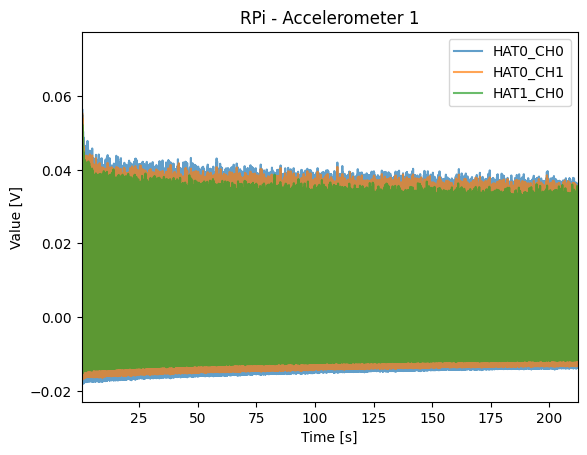

In [80]:
plot_data(data_frame, ["HAT0_CH0","HAT0_CH1","HAT1_CH0"], start_time=0.5, end_time=None, transparency=0.7, title = "RPi - Accelerometer 1")

## IRIG-B (1 channel)

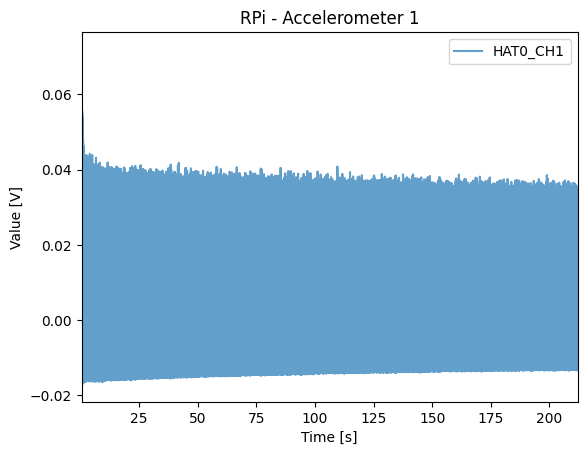

In [81]:
plot_data(data_frame, ["HAT0_CH1"], start_time=0.5, end_time=None, transparency=0.7, title = "RPi - Accelerometer 1")